In [4]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'cs231n/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment2


# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise, you will implement a dropout layer and modify your fully connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [7]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [8]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# Dropout: Forward Pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [ ]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

# Dropout: Backward Pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [ ]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less.
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:

### What happens when we don't divide by `p`
If we do not divide values by `p`, then during test time we will get wrong predictions because the network during test time will get the wrong scale of outputs than it got during training.

Without scaling the expected output of any neuron producing $\hat y$ becomes:

$$E[\hat y]=p\hat y+(1-p)0=p\hat y$$

where:
* $p\hat y$ - probability of getting the output
* $(1-p)0$ - probability of not getting the output

### What happens when we divide by `p`
Therefore, we need to scale output activations by `1/p` to ensure that the scale of outputs at test time is identical to the scale of the expected outputs at training time. i.e., when dividing by `p`, the expectation becomes:

$$E[\hat y]=\frac{p}{p}\hat y+\frac{(1-p)}{p}0=\hat y$$

Which means during test time we don't need to do anything.


# Fully Connected Networks with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the network receives a value that is not 1 for the `dropout_keep_ratio` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout_keep_ratio in [1, 0.75, 0.5]:
    print('Running check with dropout = ', dropout_keep_ratio)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        weight_scale=5e-2,
        dtype=np.float64,
        dropout_keep_ratio=dropout_keep_ratio,
        seed=123
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    # Relative errors should be around e-6 or less.
    # Note that it's fine if for dropout_keep_ratio=1 you have W2 error be on the order of e-5.
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  1
Initial loss:  2.300479089768492
W1 relative error: 7.70e-08
W2 relative error: 2.26e-04
W3 relative error: 4.56e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 1.89e-10

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 1.30e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.304275922078589
W1 relative error: 3.11e-07
W2 relative error: 5.18e-08
W3 relative error: 1.10e-07
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 9.54e-11



# Regularization Experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [ ]:
# Train two identical nets, one with dropout and one without.
np.random.seed(231)
num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout_keep_ratio in dropout_choices:
    model = FullyConnectedNet(
        [500],
        dropout_keep_ratio=dropout_keep_ratio
    )
    print(dropout_keep_ratio)

    solver = Solver(
        model,
        small_data,
        num_epochs=25,
        batch_size=100,
        update_rule='adam',
        optim_config={'learning_rate': 5e-4,},
        verbose=True,
        print_every=100
    )
    solver.train()
    solvers[dropout_keep_ratio] = solver
    print()

1
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.370000; val_acc: 0.249000
(Epoch 2 / 25) train acc: 0.458000; val_acc: 0.272000
(Epoch 3 / 25) train acc: 0.578000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.612000; val_acc: 0.283000
(Epoch 5 / 25) train acc: 0.670000; val_acc: 0.283000
(Epoch 6 / 25) train acc: 0.690000; val_acc: 0.306000
(Epoch 7 / 25) train acc: 0.744000; val_acc: 0.279000
(Epoch 8 / 25) train acc: 0.774000; val_acc: 0.310000
(Epoch 9 / 25) train acc: 0.826000; val_acc: 0.298000
(Epoch 10 / 25) train acc: 0.808000; val_acc: 0.282000
(Epoch 11 / 25) train acc: 0.818000; val_acc: 0.276000
(Epoch 12 / 25) train acc: 0.874000; val_acc: 0.291000
(Epoch 13 / 25) train acc: 0.846000; val_acc: 0.286000
(Epoch 14 / 25) train acc: 0.848000; val_acc: 0.277000
(Epoch 15 / 25) train acc: 0.904000; val_acc: 0.283000
(Epoch 16 / 25) train acc: 0.916000; val_acc: 0.282000
(Epoch 17 / 25) train acc: 0.904000; v

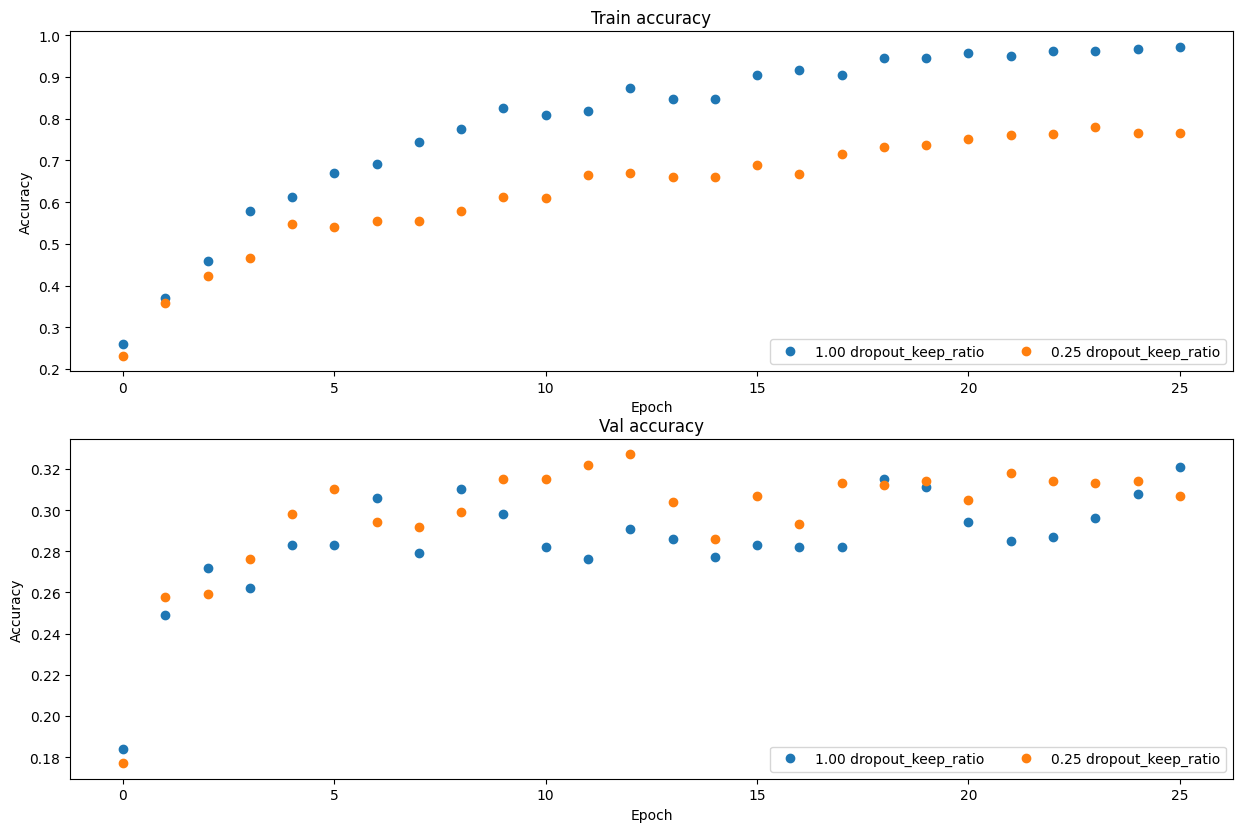

In [ ]:
# Plot train and validation accuracies of the two models.
train_accs = []
val_accs = []
for dropout_keep_ratio in dropout_choices:
    solver = solvers[dropout_keep_ratio]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].train_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].val_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:

**Training**: during training, not using _dropout_ allowed the model to achieve higher accuracies. This approach enabled the model to learn all the tiny features using all available neurons. However, it can be interpreted as a slight overfit compared to the model using _dropout_.

**Validation**: during validation, the use of _dropout_ allowed the model produce slightly better results overall, therefore, _dropout_ is a good regularizer to control overfitting - it increases network robustness because the model can't rely too much on some specific neurons.

